# The Metropolis Algorithm for 2D Ising Model

In this section, we will construct a simple implementation of the **Metropolis algorithm** to simulate the dynamics of the 2D Ising model. A single update of the Metropolis algorithm follows these steps:

1. **Random Site Selection:**
   - Choose a site $(i, j)$ randomly from the lattice.

2. **Energy Change Calculation:**
   - Calculate the energy change, $\Delta E$, that would occur by flipping the spin $s_{ij}$.

3. **Spin Flip Decision (For $\Delta E < 0$):**
   - If $\Delta E < 0$, flip the spin $s_{ij}$ with a probability of 1.

4. **Spin Flip Decision (For $\Delta E > 0$):**
   - If $\Delta E > 0$, flip the spin $s_{ij}$ with a probability of $e^{-\beta \Delta E}$, where $\beta$ is the inverse temperature.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns

## Better looking graphs
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

%matplotlib inline

#### Initial Configuration


The following function an $N \times N$ array whose elements are randomly picked from {-1, 1} with uniform probability. 

In [3]:
def create_initial_config(N=None):
    config = np.random.rand(N,N)
    for i in range (N) :
        for j in range (N) :
            if (config[i,j] <= 0.5) :
                config [i,j] = 1
            else :
                config [i,j] = -1
    return config

We create an initail configuration of size $N=100$ and display it with matplotlib:

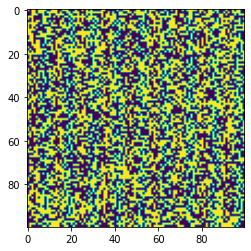

In [4]:
config = create_initial_config(N=100)
plt.imshow(config);

#### Metropolis update function

Given a site $(i, j)$, flipping $S(i, j)$ entails and energy change 
$$ \Delta E_{i,j} =  - \sum_{ <k> } (-s_{i,j}) s_k  \, \, \, + \sum_{ <k>  } s_{i,j} s_k  = 2 \sum_{ <k>} s_{i,j} s_k$$

where  < k > indicates the sum over first neighbours of the (i,j)-th site.

The following function takes a lattice configuration array and temperature as parameters and updates the configuration according to the Metropolis Algorithm. Configurations are updated *inplace*, but it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we use *periodic boundary conditions*.

In [4]:
def metropolis_single_update(config=None, T=None):
    # make sure config is square
    N, M = config.shape
    assert N==M
    
    # choose random site
    i = np.random.randint(N)
    j = np.random.randint(N)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 0
    DeltaE = config[i, j-1] + config[i-1, j]
    if(j==N-1):DeltaE += config[i, 0]
    else: DeltaE += config[i, j+1]
    if(i==N-1):DeltaE += config[0, j]
    else: DeltaE += config[i+1, j]
    DeltaE = 2*DeltaE*s
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the spin
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with Boltzmann probability
        if (np.random.rand()<np.exp(-(1/T)*DeltaE)):
            # flip the spin
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    config[i, j] = s
    
    return effDeltaE

#### Visualizing the simulation in real time
We want to simulate systems at different temperature and observe how the configuration evolves trought time using the `display` module. 

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
You can try executing the cell below at different values of the temperature, for different system size. 

In [7]:
T_c = 2/np.log(1+np.sqrt(2))

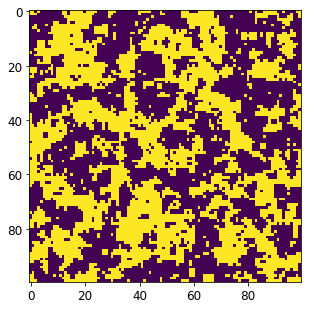

In [7]:
# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration
im = ax.imshow(config)

# evolve the system for n_steps times
n_steps = 100000
for t in range(n_steps):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

#### 
The following functions compute the energy of a configuration and tracks its evolution over time.

In [5]:
def get_energy(config):
    """
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i0, j0, i1, j1) represents two adjacent sites located
    # at (0, j0) and (i1, j1)
    horizontal_edges = [
        (i, j-1, i, j)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i-1, j, i, j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    
    return E

In [8]:
def get_energy_evolution(N, T, n_updates):

    config = create_initial_config(N)
    energy = get_energy(config)
    Es = np.array(energy)
    for t in range(n_updates):
        energy += metropolis_single_update(config,T)
        Es = np.append(Es,energy)
    
    return Es

In the subsequent cell, we computed the energy of our system and visualized it over time. We can discern an initial period of dynamic evolution of the system as it converges towards equilibrium the final equilibrium phase. Here, the energy stabilizes, indicating that the system has reached a state of relative stability.

In [11]:
# 20 x 20 grid at critical temperature for 50.000 update steps
energy_evolution = get_energy_evolution(20, T_c, 50000)

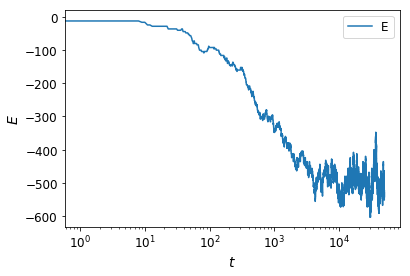

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogx(energy_evolution, label="evolution")
ax.set_xlabel("$t$")
ax.set_ylabel("$E$")
ax.legend("Energy")
plt.show();

### Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book 'Statistical Mechanics: Entropy, Order Parameters and Complexity', which is much more efficient and can be found here:
[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html).

To import code from an external file, we need to add its directory to the PATH:


In [13]:
import sys
sys.path.append("SethnasBookCode/")
from Ising import IsingModel

Their implementation is based on a class, which means we need to instantiate the model:

In [16]:
# create an instance of IsingModel
ising = IsingModel(N=100)

# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

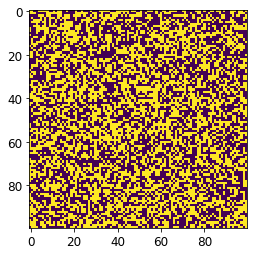

In [18]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1. To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code source file at `SethnasBookCode/Ising.py`.

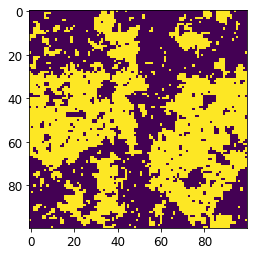

In [20]:
ising.SweepMetropolis(nTimes=100)
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. You can try changing some values and see what happens.

In [14]:
#################
# set parameters
system_size = 80
H = -0.1
T_below = 0.3
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 10
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

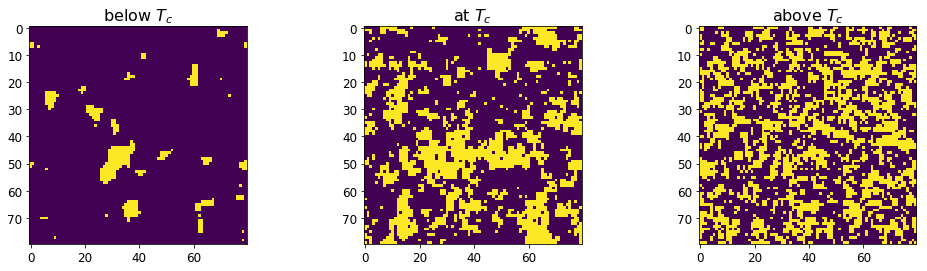

In [15]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Magnetization
In this section, our focus shifts to computing the magnetization ($M$) in relation to the temperature ($T$). To enhance simulation efficiency, we'll leverage the Wolff algorithm, conveniently implemented in Sethna's code through the `.SweepWolff()` method.

To assess the equilibrium state of the system, we examine the mean value of all elements in the lattice. A mean value approaching $0.5$ indicates that the system can be considered in equilibrium. The equilibrium condition is temperature-dependent:

- **Above Critical Temperature:**
  - At temperatures higher than the critical point, achieving equilibrium is straightforward. The empirical mean closely aligns with the theoretical value.

- **Critical Temperature:**
  - At the critical temperature, the system exhibits irregular oscillations between phases of quasi-complete magnetization, adding a dynamic dimension to the equilibrium assessment.

- **Below Critical Temperature:**
  - For temperatures below the critical point, the system undergoes rapid magnetization. The Wolff algorithm facilitates this evolution, leading to a mean value approaching 1 in a few steps.



In [28]:
# set system size, temperature
system_size = 100 
temperature = 5
steps_num = 300
graph_check_y = np.zeros(steps_num)

# run some Wolff sweeps, check if equilibrium
m_ising = IsingModel(system_size, temperature)
for i in range(steps_num):
    m_ising.SweepWolff()
    graph_check_y[i] = np.mean(m_ising.lattice)

In [29]:
absc = np.zeros(steps_num)
theoretical_graph = np.zeros(steps_num)
for i in range (steps_num):
    absc[i]=i
    theoretical_graph[i] = 0.5

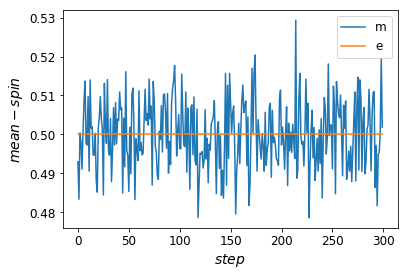

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(absc, graph_check_y, label="Wolff_equilibrium")
ax.plot(absc, theoretical_graph, label="teorethical_equilibrium")
ax.set_xlabel("$step$")
ax.set_ylabel("$mean-spin$")
ax.legend("mean")

The following function computes the magnetization of a 2D Ising system after certain equilibration period.

In [35]:
def calculate_magnetization(system_size, temperature, equilibration_time):
    # instantiate model
    m_ising = IsingModel(system_size, temperature)
    # equilibrate
    m_ising.SweepWolff(equilibration_time)
    # compute magnetization
    m = np.mean(m_ising.lattice*2-1) #so that equilibrium is renormalized to zero
    return m


In the following cell we compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$. We then plot $|M|$ as a function of $T$ to illustrate phase behavior.

In [69]:
system_size = 64
equilibration_time = 100
temperatures = np.linspace(1.5, 3.5, num=100)

magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

Text(0, 0.5, '$M$')

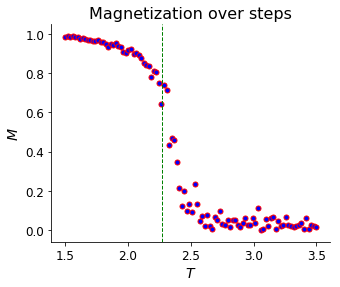

In [72]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, np.abs(magnetizations),
    edgecolors="red", color="blue", s=25
)
ax.axvline(T_c,c="green", lw=1, ls = "dashed") ## Critical temperature vertical line
ax.set_title("Magnetization over steps")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$")
plt.show();


Observing the behavior of the system at different temperature values reveals distinct magnetization phases:

- **Paramagnetic Phase (High Temperatures):**
  - At elevated temperature values, the system predominantly resides in the paramagnetic phase. During this phase, the average magnetization approaches zero, indicating a balanced distribution of spins.

- **Critical Temperature ($T_c$):**
  - As the temperature decreases, especially around the critical temperature ($T_c$), a notable transition occurs. The magnetization undergoes an abrupt increase. This phase transition signifies a shift towards a more ordered, magnetized state.

- **Magnetized Phase (Low Temperature):**
  - As the temperature further decreases, the maximum values of $1$ is reached. This values of the order parameter indicate a global order in the systems. 


#### Susceptibility and Specific Heat

At **equilibrium**, we can assume that fluctuations and the susceptibilities are related via the fluctuation-dissipation theorem.
We will then compute the specific heat $C$ and the magnetic susceptibility $\chi$ as:
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle,
$$ 

$$
\chi = \frac{1}{T} \left\langle (M - \langle M \rangle)^2 \right\rangle.
$$

In [71]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    #######
    horizontal_edges = [
        (i, j-1, i, j)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i-1, j, i, j)
        for i in range(N) for j in range(N)
    ]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]

    return E / N**2

In [79]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    """
    # initiate model
    m_ising = IsingModel(system_size, temperature)
    # thermalize (hopefully!)
    m_ising.SweepWolff(equilibration_time)
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for k in range(n_samples):
        # change from 0,1 to -1,1 notation
        config = m_ising.lattice*2-1
        # get magnetization
        m = np.abs(config.mean())
        ms.append(m); m2s.append(m**2)
        # get energy
        e = compute_energy(m_ising)
        es.append(e); e2s.append(e**2)
        # update system
        m_ising.SweepWolff()
    
    # compute susceptibility and specific heat
    susceptibility = 1/temperature*(np.mean(m2s)-np.mean(ms)**2)
    specific_heat = 1/temperature**2*(np.mean(e2s)-np.mean(es)**2)
    
    return susceptibility, specific_heat



For a small system of size $N=25$ and a temperatures range of $T \in [1.5, 3.5]$ we obtain the following results:

In [80]:
temperatures = np.linspace(1.5, 3.5, num=50)
system_size = 25
equilibration_time = 100
n_samples = 25

susceptibilities = []
specific_heats = []
for temperature in temperatures:
    susceptibility, specific_heat = calculate_susceptibility_specific_heat(system_size, temperature, 
                                                                           equilibration_time, n_samples)
    susceptibilities.append(susceptibility)
    specific_heats.append(specific_heat)


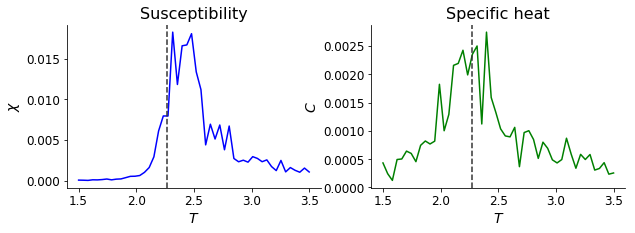

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax=ax1
ax.plot(temperatures, susceptibilities, color="blue")
ax.axvline(T_c, color="0.2", ls="dashed")
ax.set_ylabel("$\chi$")
ax.set_xlabel("$T$")
ax.set_title("Susceptibility")

ax=ax2
ax.plot(temperatures, specific_heats, color="green")
ax.axvline(T_c, color="0.2", ls="dashed")
ax.set_ylabel("$C$")
ax.set_xlabel("$T$")
ax.set_title("Specific heat");

As the system approaches the critical temprature the susceptibility and the specific heat exhibit a peak of magnitude. Around the critical temperature the order parameter field (i.e., magnetization) becomes more *susceptible* to fluctuations - or to the direct perturbation of an external field. This situation implies a significant enforcement of the possibility of the symmetry brokerage for the order parameter - which is in the end consistent with the factual phase transition.

#### Cluster Size
It might be interesting to study the cluster size in different configurations.
For this puropus, I wrote a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.
The function is then tested on some configurations of different sizes.

In [5]:
def get_labels(config):
    n=0
    N = len(config[0,:])
    matrix=np.zeros(shape=(N,N))
    dictionary = {}
    loop = False
    debug = False
    debugLargeMatrix = False
    for r in range(N):
        for s in range(N):
            if(s!=0):
                #print("@("+str(r)+","+str(s)+"): " + str(config[r][s-1])+" vs "+str(config[r][s]))
                if(config[r][s-1] != config[r][s]):
                    n+=1
            matrix[r][s] = n
            if(r!=0 and config[r][s] == config[r-1][s]):
                    if(debug):print(matrix)
                    if(debug):print(dictionary)
                    if (matrix[r][s]) in dictionary:
                        if(matrix[r-1][s-1]!=dictionary[matrix[r][s]]):
                            if(debug):print("@("+str(r)+","+str(s)+"): ")
                            cur_i = matrix[r-1][s]
                            loop = True
                            while(loop):
                                if(debug):print("cur_i = " + str(cur_i))
                                if cur_i in dictionary:
                                    cur_i = dictionary[cur_i]
                                else:
                                    new_key = dictionary[matrix[r][s]]
                                    if new_key in dictionary:
                                        if dictionary[new_key]!=cur_i:
                                            if(cur_i!=new_key):dictionary[cur_i] = new_key
                                    if(cur_i!=new_key):dictionary[cur_i] = new_key
                                    loop=False
                    else:
                        if matrix[r-1][s] in dictionary:
                            if dictionary[matrix[r-1][s]]!=matrix[r][s]:
                                if(matrix[r][s]!=matrix[r-1][s]):dictionary[matrix[r][s]] = matrix[r-1][s]
                        if(matrix[r][s]!=matrix[r-1][s]):dictionary[matrix[r][s]] = matrix[r-1][s]
                    for key in dictionary:
                        old_key = key
                        while dictionary[key] in dictionary:
                            key = dictionary[key]
                        dictionary[old_key] = dictionary[key]
        n+=1
        if(debugLargeMatrix):print(n)
    #simplify dictionary
    if(debug):print(matrix)
    if(debug):print(dictionary)       
    #return labels
    for r in range(N):
        for s in range(N):
            if matrix[r][s] in dictionary:
                matrix[r][s] = dictionary[matrix[r][s]]
    for r in range(N):
        for s in range(N):
            if matrix[r][s] in dictionary:
                matrix[r][s] = dictionary[matrix[r][s]]
    return matrix

In [ ]:
config_test_0 = np.array([[ 1,  -1,  1],
                          [1, -1,  1],
                          [1, 1,  1]])

In [ ]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [ ]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


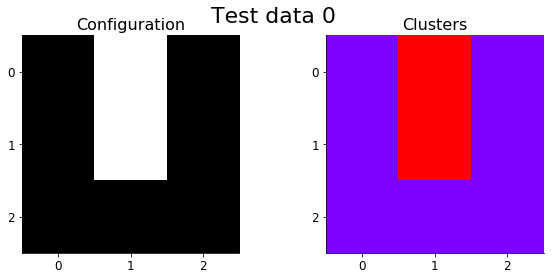

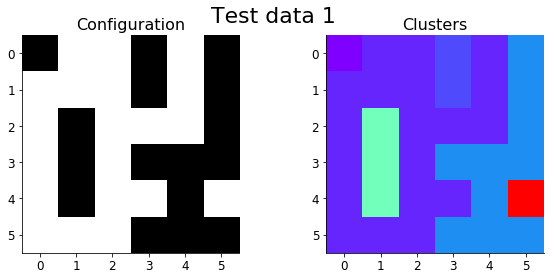

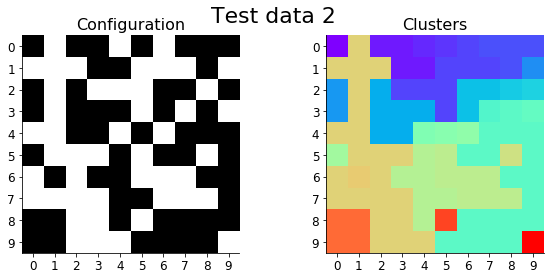

In [ ]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

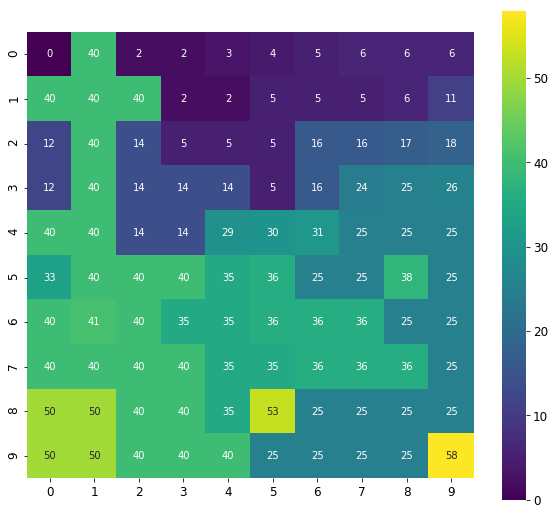

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

We can use this function on a large Ising Model (like, N=500) to study the distribution of cluster size. 


In [ ]:
# Initialize
system_size = 500
temperature = 2.269185314213022 ##critical temperature
ising = IsingModel(N=system_size, T=temperature)
ising.SweepWolff(nTimes=30)
config = ising.lattice*2-1

# Get labels
labels = get_labels(config)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50,20))
#ax1.set_title("Configuration")
ax2.set_title("Clusters")
#ax1.imshow(config, cmap="Greys")
ax2.imshow(labels, cmap="viridis")

In [ ]:
from collections import Counter
def get_sizes(labels):
    n = len(labels)
    array = np.reshape(labels, n*n)
    c = Counter(array)
    sizes = list(c.values())
    return sizes

In [ ]:
#using SweepMetropolis algorithm
system_size = 200
H = 0.0
T = 30
n_sweeps = 50

config  = IsingModel(N=system_size, T=T, H=H)
config.SweepMetropolis(nTimes=n_sweeps)
labels = get_labels(config.lattice)
sizes = get_sizes(labels)

Text(0.5, 0, 'Cluster size')

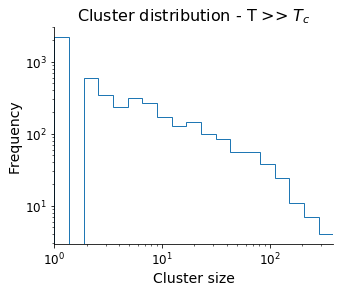

In [ ]:
# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Cluster distribution - T >> $T_c$")
ax.set_xlim(min(sizes), max(sizes))
ax.set_ylabel("Frequency")
ax.set_xlabel("Cluster size")
plt.show();

If the temperature of the system is highly above the critical point the system should not exhibit large size clusters. Eventually small cluster may form, but significantly smaller than the ones at the critical point.


In [ ]:
# do simulation
#using SweepMetropolis algorithm
system_size = 200
H = 0.0
T_c = 2.269185314213022
n_sweeps = 50


config  = IsingModel(N=system_size, T=T_c, H=H)
config.SweepMetropolis(nTimes=n_sweeps)
labels = get_labels(config.lattice)   
sizes = get_sizes(labels)

Text(0.5, 0, 'Cluster size')

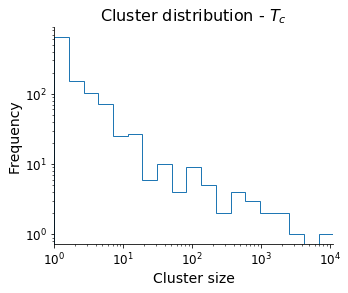

In [ ]:
# plot results
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Cluster distribution - $T_c$")
ax.set_xlim(min(sizes), max(sizes))
ax.set_ylabel("Frequency")
ax.set_xlabel("Cluster size")
plt.show();

The distribution is polinomial, like the previous. In this case the distribution exhibits a significant frequency for bigger size clusters - there is a noticeable amount of clusters up to one order of magnitude more than the previous one ($10^3$). Also, smaller size clusters have lower frequencies than the previous case.
At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.
$$
P(s) \propto s^{-\alpha}
$$